In [283]:
import os
import pandas as pd
import numpy as np
from importlib import reload
from PATH import data_path
from importlib import reload
import utils
import Model

In [208]:
from matplotlib import pyplot as plt

In [3]:
from sklearn import preprocessing,decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [357]:
from sklearn.metrics import roc_auc_score

In [149]:
from sklearn.model_selection import train_test_split

In [364]:
reload(utils)
reload(Model)
from utils import *
from Model import *

In [7]:
pj = os.path.join

## Loading data

In [13]:
label = pd.read_csv(pj(data_path,'TCGA_BRCA_Her2.csv'))

In [16]:
data_DF = pd.read_csv(pj(data_path,'whole_matrix.csv')).rename({'Unnamed: 0':'id'},axis=1)

In [140]:
nega_idx=np.where(label.iloc[:,1] == 'Negative')[0]
posi_idx=np.where(label.iloc[:,1] == 'Positive')[0]

### sample id in `label` is truncated

In [41]:
# make it a new columns
data_DF.loc[:,'SHORT_ID'] = data_DF.id.apply(lambda x: '-'.join(x.split('-')[:3]))
data_DF.pop('id');
# set it as index
data_DF=data_DF.set_index('SHORT_ID')

In [8]:
data = np.load(pj(data_path,'WHOLE_MATRIX.npy'))

## Scale data

In [46]:
data_normed=preprocessing.scale(data)

/home/ZwZ/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/ZwZ/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


### appearantly , there are data that always 0, try kick them out

In [81]:
problem_gene=np.where(np.std(data_normed,axis=0) == 0)[0]
keep_gene = [i for i in range(data.shape[1]) if i not in problem_gene]

In [84]:
data = data[:,keep_gene]
data_DF =data_DF.iloc[:,keep_gene];

## <font color='navy'> | >> save to new csv << |

In [98]:
np.save(pj(data_path,'clean_matrix.npy'),data)
data_DF.to_csv(pj(data_path,'clean_DF.csv'),index=True)

## scale with clean data

In [111]:
data_norm = preprocessing.scale(data)

/home/ZwZ/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/ZwZ/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


## PCA decomposition

In [440]:
PCA = decomposition.PCA(n_components=0.9)

In [492]:
x = PCA.fit_transform(data_norm)

In [493]:
x.shape

(1222, 545)

## split train test

In [270]:
# PCA 
X=np.concatenate([x[nega_idx,:],x[posi_idx,:]],axis=0)

# just scale
d_X=np.concatenate([data_norm[nega_idx,:],data_norm[posi_idx,:]],axis=0)

# y
y = np.array([0]*len(nega_idx)+[1]*len(posi_idx))

## try LDA

In [466]:
# decomposed
X_train, X_val, X_test, y_train, y_val, y_test=split_check_ratio(bal_X,bal_y,val=True)
lda=LDA_model(X_train, X_val, y_train, y_val)

the ratio of whole	set is 0.5
the ratio of train	set is 0.4891304347826087
the ratio of val	set is 0.47619047619047616
the ratio of test	set is 0.5280898876404494


In [467]:
lda.f1,lda.auc

(0.631578947368421, 0.7454545454545455)

In [465]:
lda.cm

array([[9, 3],
       [5, 4]])

## try SVM

In [ ]:
SVC()

In [291]:
def SV(**kwarg):
    return SVC_model(X_train, X_val, y_train, y_val,**kwarg)

In [351]:
SV_ls = [SV(**{'C':50,'gamma':i}) for i in [0.01,0.1,1,10,50]]

Text(0.5, 1.0, 'f1 for PCA data')

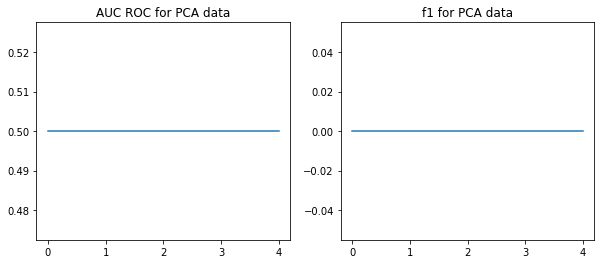

In [352]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot([SV.auc for SV in SV_ls]);
plt.title('AUC ROC for PCA data')
plt.subplot(1,2,2)
plt.plot([SV.f1 for SV in SV_ls]);
plt.title('f1 for PCA data')

## balanced data

### <font color='fire'> just scale

In [409]:
dx_nega=data_norm[np.random.choice(nega_idx,len(posi_idx)),:]

# balanced data : by under sampling
bal_DX=np.concatenate([dx_nega,data_norm[posi_idx,:]],axis=0)
bal_y = np.array([0]*dx_nega.shape[0] +[1]*dx_nega.shape[0])
X_train, X_test, y_train, y_test=split_check_ratio(bal_DX,bal_y,val=False)

the ratio of whole	set is 0.5
the ratio of train	set is 0.5170731707317073
the ratio of test	set is 0.4606741573033708


### <font color='navy'> decomposed

In [494]:
x_nega=x[np.random.choice(nega_idx,len(posi_idx)),:]

# balanced data : by under sampling
bal_X=np.concatenate([x_nega,x[posi_idx,:]],axis=0)
bal_y = np.array([0]*dx_nega.shape[0] +[1]*dx_nega.shape[0])
X_train, X_test, y_train, y_test=split_check_ratio(bal_X,bal_y,val=False)

the ratio of whole	set is 0.5
the ratio of train	set is 0.5024390243902439
the ratio of test	set is 0.4943820224719101


In [495]:
X_train.shape

(205, 545)

## Grid search

In [354]:
from sklearn.model_selection import GridSearchCV

In [496]:
params = {'C':[0.1,1,10,50],'gamma':[0.01,0.1,1,10,50],'kernel':['linear','rbf','poly']}

In [504]:
clf = GridSearchCV(estimator=SVC(kernel='rbf',probability=True),n_jobs=8,param_grid=params,cv=7)

In [505]:
clf.fit(X_train,y_train)

GridSearchCV(cv=7, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.1, 1, 10, 50], 'gamma': [0.01, 0.1, 1, 10, 50],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [506]:
joblib.dump(clf,os.path.join(data_path,'Gridsearch_PCA0.9_2.result'))

['/home/ZwZ/database/BRACA/Gridsearch_PCA0.9_2.result']

In [507]:
model = clf.best_estimator_

In [508]:
f1_score(y_test,model.predict(X_test))

0.704

In [509]:
roc_auc_score(y_test,model.predict_proba(X_test)[:,1])

0.5752525252525251

In [503]:
X_test.shape

(89, 545)